In [5]:
"""Script to plot a learning rate scheduler"""

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch.optim import SGD

from src.config.training_config import OptimizationConfig, TrainingConfig
from src.training.utils.initialization import initialize_lr_scheduler

MAX_STEPS = 30_000
LR_WARMUP_STEPS = 2_000
RESTART_WARMUP_STEPS = 100
RELORA_RESET_FREQ = 2_000

# Set the style for seaborn
sns.set_theme(font_scale=1.8, rc={"axes.grid": "True", "axes.grid.which": "both"})

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join([r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}"]),
}
matplotlib.rcParams.update(rc_fonts)

In [13]:
def plot(scheduler, out_fp):
    """Plot learning rate"""
    optimizer = SGD([torch.tensor(1)], lr=1)

    training_config = TrainingConfig(
        None,
        OptimizationConfig(
            lr=1,
            lr_scheduler=scheduler,
            lr_warmup_steps=LR_WARMUP_STEPS,
            restart_warmup_steps=RESTART_WARMUP_STEPS,
            min_lr_ratio=0.1,
        ),
        max_steps=MAX_STEPS,
    )

    training_config.relora_reset_freq = RELORA_RESET_FREQ

    scheduler = initialize_lr_scheduler(training_config, optimizer)

    fig, ax = plt.subplots(figsize=(14, 8))

    # Collect learning rates
    steps = np.arange(MAX_STEPS)
    lrs = []
    for _ in range(MAX_STEPS):
        optimizer.step()
        lrs.append(scheduler.get_last_lr()[0])  # Get scalar value
        scheduler.step()

    # Create seaborn line plot
    sns.lineplot(x=steps, y=lrs, ax=ax)

    plt.xlabel("Training step")
    plt.ylabel("Learning rate multiplier")

    # ax.set_xlabel("Step / 1000", size=23)
    # ax.set_ylabel("Learning rate multiplier", size=23)

    # # Set ticks
    # ticks = np.arange(0, MAX_STEPS + 1, step=RELORA_RESET_FREQ)
    # ax.set_xticks(ticks)
    # ax.set_xticklabels(ticks // 1000)
    # ax.set_yticks(np.arange(0, 1.01, 0.1))
    # ax.tick_params(axis="both", labelsize=18)

    # Adjust layout and save
    fig.tight_layout()
    fig.savefig(out_fp)
    plt.show()

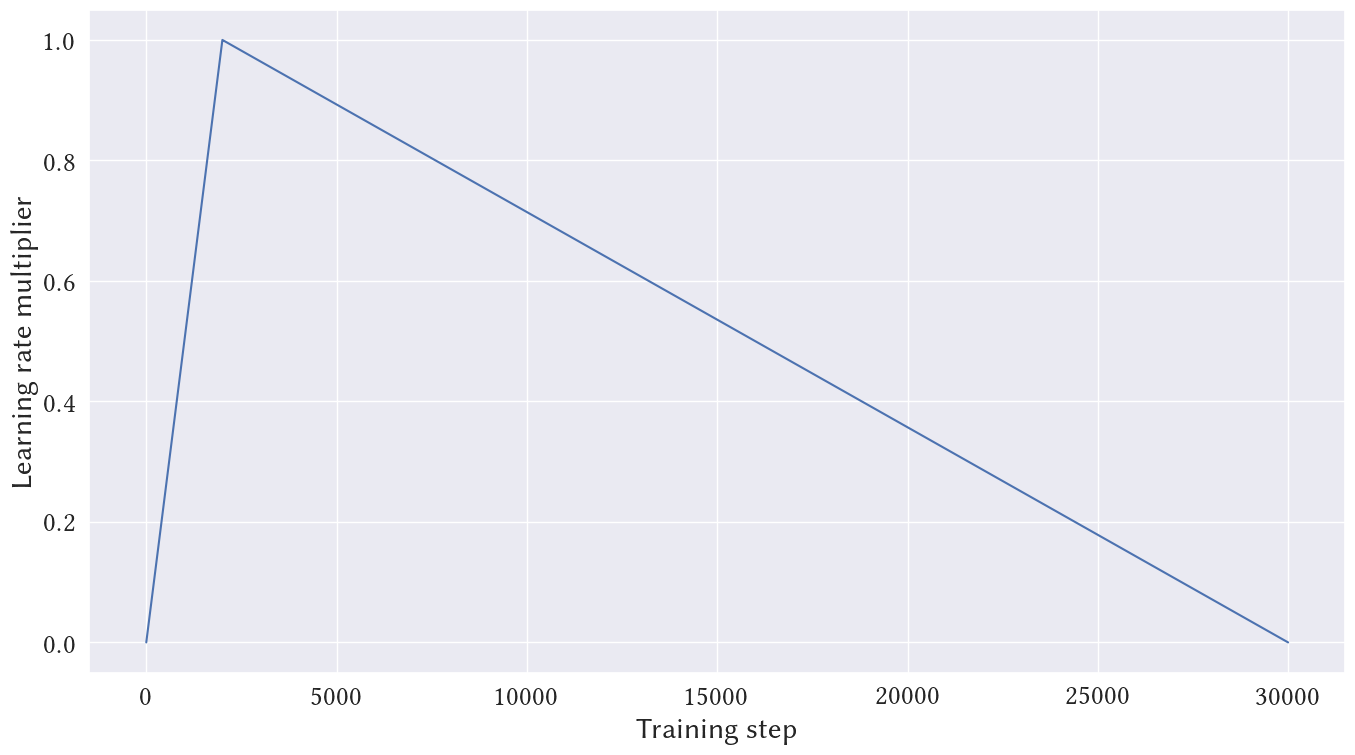

In [14]:
plot("linear_with_warmup", "../graphs/linear_scheduler.pdf")

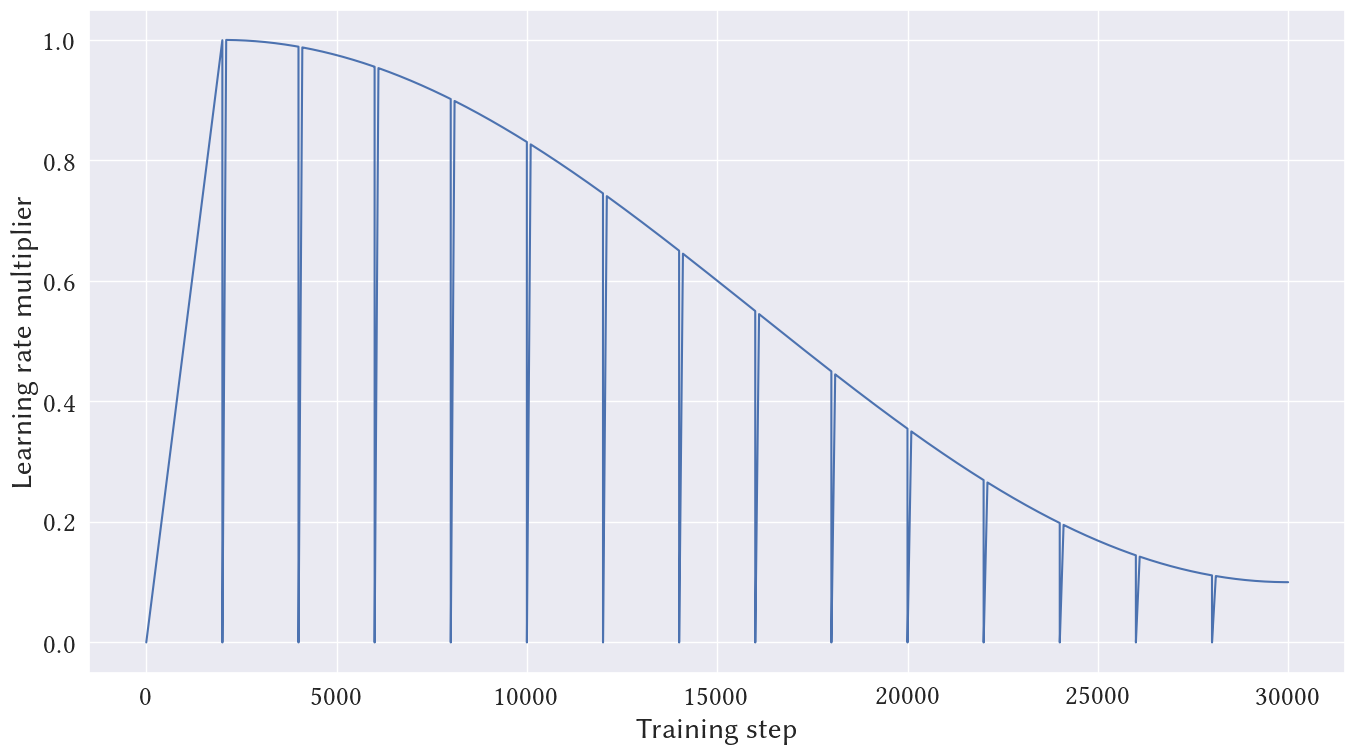

In [15]:
plot("relora_jagged_cosine", "../graphs/lr_scheduler.pdf")